<a href="https://colab.research.google.com/github/CarlosVaquero/BudgetBuddy/blob/main/tijl_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/CarlosVaquero/BudgetBuddy/

Cloning into 'BudgetBuddy'...
remote: Enumerating objects: 918, done.
remote: Counting objects: 100% (918/918), done.
remote: Compressing objects: 100% (852/852), done.
remote: Total 918 (delta 66), reused 914 (delta 64), pack-reused 0 (from 0)
Receiving objects: 100% (918/918), 504.58 KiB | 8.01 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [226]:
!pip install langchain_community
!pip install langchain-google-genai
!pip install langchain-chroma
!pip install faiss-cpu
!pip install -U langgraph
!pip install html2text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for html2text: filename=html2text-2024.2.26-py3-none-any.whl size=33111 sha256=248d25f9952f621b0c1cc459847d8dc066f7009408b16ca5aaf32691c0a8ebff
  Stored in directory: /root/.cache/pip/wheels/23/58/7c/d9c8c4d924a1ac2b621add1b2c1d30b639629a33cfdfde6a45
Successfully built html2text


In [227]:
import os
import getpass
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.vectorstores import FAISS
from langchain.tools.retriever import create_retriever_tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display, Markdown
import textwrap
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, trim_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
import random
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer


In [110]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ['GOOGLE_API_KEY'] = getpass.getpass('Gemini API Key:')

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

## Define the LLM to use

In [111]:
# Create LLM model
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_retries=2
)

## Create the vector store

In [334]:
def load_vector_store(
    documents,
    vector_store_path: str = "BudgetBuddy/vectorstore/ingnl",
    embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004"),
    overwrite: bool = False
):
    if overwrite:
        # Refresh the vector store
        db_faiss = store_docs_as_vector_store(documents, vector_store_path, embeddings)
        print("Saved vector store to file")
    else:
        # Try loading it from file
        try:
            db_faiss = FAISS.load_local(
                vector_store_path, embeddings, allow_dangerous_deserialization=True
            )
            print("Loaded vector store from file")
        except Exception:
            # Can't find it, so refresh the database
            db_faiss = store_docs_as_vector_store(documents, vector_store_path, embeddings)
            print("Saved vector store to file")
    return db_faiss

def store_docs_as_vector_store(
    documents,
    vector_store_path: str = "BudgetBuddy/vectorstore/ingnl",
    embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
):
    db_faiss = FAISS.from_documents(documents, embeddings)
    db_faiss.save_local(vector_store_path)
    return db_faiss

### Add ing.nl data

In [326]:
# Specify the directory
directory = 'BudgetBuddy/data/ingnl'

# Create an empty list to store file paths
file_paths = []

# Walk through the directory
for root, dirs, files in os.walk(directory):
    for file in files:
        # Join the root directory with the file name to get the full path
        full_path = os.path.join(root, file)
        # Append the full path to the list
        file_paths.append(full_path)

In [327]:
# Load the document, split it into chunks, embed each chunk and load it into the vector store.
documents = []
for file_path in file_paths:
    documents.extend(TextLoader(file_path).load())

In [329]:
db_ingnl = load_vector_store(
    documents,
    vector_store_path="BudgetBuddy/vectorstore/ingnl",
    embeddings=GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
)

Loaded vector store from file


In [330]:
query = "Kan ik mijn creditcard transacties zien in Kijk Vooruit?"
docs = db_ingnl.similarity_search(query)
for i, doc in enumerate(docs):
    print(f"\n\nDocument {i+1}:")
    print(doc.page_content)



Document 1:
# Creditcard rekeningoverzicht in Mijn ING en de Mobiel Bankieren App - ING

### Waarom zie ik niet dezelfde transacties als mijn partner?

Heb je een extra creditcard? Dan zie je altijd alleen de transacties die met die creditcard gedaan zijn. De transacties van je partner zie je niet terug in je rekeningoverzicht. Hierdoor kan het zijn dat het saldo niet lijkt te kloppen. Wat je ziet is het actuele beschikbare saldo voor beide creditcards. De hoofdkaarthouder ziet op zijn beurt wel alle transacties in het overzicht terug, ook die met de extra creditcard zijn gedaan. Met welke creditcard de transactie is gedaan zie je aan de laatste 4 cijfers die bij de transactie staan.
Houd er rekening mee dat je alleen het creditcard rekeningoverzicht ziet van de persoon die is ingelogd in de Mobiel Bankieren App of Mijn ING. Indien je een gezamenlijke rekening hebt, dan is de maandelijkse afschrijving inzichtelijk voor beide rekeninghouders.


Document 2:
# Creditcard rekeningoverzic

### Add nibud.nl data

In [331]:
urls = [
    "https://www.nibud.nl/onderwerpen/kinderen-en-jongeren/",
    "https://www.nibud.nl/onderwerpen/kinderen-en-jongeren/zakgeld-en-kleedgeld/",
    "https://www.nibud.nl/onderwerpen/kinderen-en-jongeren/wat-kost-een-kind/",
    "https://www.nibud.nl/onderwerpen/kinderen-en-jongeren/studeren/",
    "https://www.nibud.nl/onderwerpen/kinderen-en-jongeren/financiele-opvoeding/",
    "https://www.nibud.nl/onderwerpen/kinderen-en-jongeren/je-kind-wordt-18-jaar/",
    "https://www.nibud.nl/onderwerpen/kinderen-en-jongeren/kostgeld/",
    "https://www.nibud.nl/onderwerpen/uitgaven/",
    "https://www.nibud.nl/onderwerpen/uitgaven/huishoudelijke-uitgaven/",
    "https://www.nibud.nl/onderwerpen/uitgaven/autokosten/",
    "https://www.nibud.nl/onderwerpen/uitgaven/vergelijk-uitgaven/",
    "https://www.nibud.nl/onderwerpen/uitgaven/kosten-verzekering/",
    "https://www.nibud.nl/onderwerpen/uitgaven/kosten-energie-water/",
    "https://www.nibud.nl/onderwerpen/uitgaven/geld-besparen/",
    "https://www.nibud.nl/onderwerpen/uitgaven/abonnementen/",
    "https://www.nibud.nl/onderwerpen/scheiden/",
    "https://www.nibud.nl/onderwerpen/scheiden/geldzaken-bij-een-scheiding/",
    "https://www.nibud.nl/onderwerpen/scheiden/co-ouderschap/",
    "https://www.nibud.nl/onderwerpen/scheiden/alimentatie/",
    "https://www.nibud.nl/onderwerpen/scheiden/scheiden-en-pensioen/"
]
loader = AsyncHtmlLoader(urls)
docs = loader.load()

Fetching pages: 100%|##########| 20/20 [00:05<00:00,  3.36it/s]


In [332]:
html2text = Html2TextTransformer()
docs_transformed = html2text.transform_documents(docs)
text_splitter = CharacterTextSplitter(chunk_size=3000, chunk_overlap=0)
documents = text_splitter.split_documents(docs_transformed)

In [333]:
db_nibudnl = load_vector_store(
    documents,
    vector_store_path="BudgetBuddy/vectorstore/nibudnl",
    embeddings=GoogleGenerativeAIEmbeddings(model="models/text-embedding-004"),
    overwrite=True
)

In [337]:
query = "Ik ga scheiden. Hoe zit het dan met de kinderen?"
docs = db_nibudnl.similarity_search(query)
for i, doc in enumerate(docs):
    print(f"\n\nDocument {i+1}:")
    print(doc.page_content)



Document 1:
Direct naar content

  * Nieuws
  * Webwinkel

Menu

  * Onderwerpen
    * Rondkomen
    * Sparen
    * Uitgaven
    * Geldproblemen
    * Inkomensondersteuning
    * Kinderen en jongeren
    * Wonen
    * Pensioen
    * Uit elkaar
    * Werken
  * Dossiers
    * Voldoende inkomen
    * Financiële weerbaarheid
    * Betaalbaar wonen
    * Betaalbare energietransitie
  * Samenwerken
    * Voorlichting op maat
    * Onderzoek en advies
    * Deskundigheidsbevordering
    * Cijfers en rekentools
    * Cursussen, workshops en coaching
    * Werkvelden
  * Over het Nibud
    * Over de organisatie
    * Onze missie en impact
    * Financiering
    * Samenwerken met het Nibud
    * Werken bij het Nibud
    * Informatie voor pers
    * Medewerkers
    * Contact met het Nibud

  * Nieuws
  * Webwinkel

  * Onderwerpen
    * Rondkomen
    * Sparen
    * Uitgaven
    * Geldproblemen
    * Inkomensondersteuning
    * Kinderen en jongeren
    * Wonen
    * Pensioen
    * Uit elkaar
  

### Create the Vector Database Retriever tool

In [338]:
ingnl_retriever = db_ingnl.as_retriever(
    # search_type="mmr",
    search_kwargs={"k": 5},
)
nibudnl_retriever = db_nibudnl.as_retriever(
    # search_type="mmr",
    search_kwargs={"k": 5},
)

In [339]:
ingnl_retriever_tool = create_retriever_tool(
    ingnl_retriever,
    "retrieve_ingnl_information",
    "Search and return information about (banking) products of ING, and features in the ING app that customers have available.",
)
nibudnl_retriever_tool = create_retriever_tool(
    nibudnl_retriever,
    "retrieve_nibudnl_information",
    "Nibud.nl is the website of the National Institute for Family Finance Information (Nibud) in the Netherlands. This independent foundation provides information and advice on managing personal finances. The site offers tools, tips, and research to help individuals and households make informed financial decisions. You might want to visit Nibud.nl if you need guidance on budgeting, saving, or managing debt. It's also useful for understanding household expenses, planning for retirement, or seeking advice on financial health"
)

### Create a Tavily Search tool

In [340]:
search_tool = TavilySearchResults(max_results=2)
search_tool.description

'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.'

## Combine all the tools

In [341]:
tools = [ingnl_retriever_tool, nibudnl_retriever_tool, search_tool]
tools_names = {t.name: t for t in tools}
model = model.bind_tools(tools)

### Some helper functions

In [342]:
def wrap_text(text, width=100):
    text_split = text.split("\n")
    wrapped_text = textwrap.fill(text_split[0], width)
    if len(text_split) > 1:
        for line in text_split[1:]:
            wrapped_text += "\n" + textwrap.fill(line, width)
    return wrapped_text

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            print(wrap_text(message.pretty_repr()))

class FinHealthAgentSession:
    def __init__(self, agent):
        self.agent = agent
        self.start_session()

    def ask(self, question, verbose=False):
        messages = [HumanMessage(content=question)]
        tools_used = []
        if verbose:
            print_stream(self.agent.stream({"messages": messages}, config=self.session, stream_mode= "values"))
        else:
            result = self.agent.invoke({"messages": messages}, config=self.session)
            for i, message in enumerate(reversed(result['messages'])):
                if message.content == question:
                    break
            for message in result['messages'][len(result['messages']) - i:]:
                if message.name != None:
                    tools_used.append(message.name)
            print(f"Tools used: {tools_used}\n")
            display(Markdown(wrap_text(result['messages'][-1].content)))

    def start_session(self):
        session_id = ''.join(random.choices('0123456789', k=6))
        print(f"Started session {session_id}...")
        self.session = {"configurable": {"thread_id": session_id}}

## Create the agent

Started session 539328...


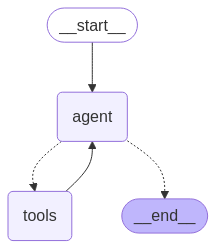

In [347]:
prompt = """
    You are a helpful assistant representing both ING Bank and Nibud
    (Dutch institute for budgeting education).
    Your goal is to find a satisfying answer to each question of a customer.
    You can assume that any human asking you a question, is an ING customer.
    If necessary, decompose the question into multiple tasks, and try
    to use the tools at your disposal to answer the subtasks before coming
    up with the final answer.
    Don't ask the user for confirmation.
    Just do stuff.
    Try to pitch features or products of ING inside your answers when that would
    be potentially benefitial for the customer. Only do that when that pitch is
    relevant to the question asked by the customer. So don't pitch stuff not really
    related to the question.
    For this you could use the ingnl_retriever_tool to find relevant features and
    products of ING.
    Also make sure to add any relevant suggestions or recommendations from Nibud
    if this would be helpful for the customer. For this you can use the
    nibudnl_retriever_tool.
    Make sure to use both tools whenever it may even be slightly useful! If you
    don't find something relevant from these tools, you don't need to incorporate
    what you found in the answer. Just ignore it then.
    Make sure to always answer in the same language you were asked the question in.
"""

memory = MemorySaver()
agent = create_react_agent(model, tools, prompt=prompt, checkpointer=memory)
session = FinHealthAgentSession(agent)
display(Image(session.agent.get_graph().draw_mermaid_png()))

In [348]:
session.ask("Welke transacties zie ik allemaal in Kijk Vooruit?")

Tools used: ['retrieve_ingnl_information', 'retrieve_nibudnl_information']



In Kijk Vooruit in de Mobiel Bankieren App van ING zie je de volgende transacties:

*   **Afschrijvingen die zeker gaan gebeuren:** Dit zijn bijvoorbeeld vaste lasten zoals huur of
hypotheek.
*   **Afschrijvingen die voorspeld worden:** Op basis van eerdere afschrijvingen, zoals je
energierekening, wordt een voorspelling gedaan.
*   **Bijschrijvingen die voorspeld worden:** Op basis van eerdere bijschrijvingen, zoals je
salaris, wordt een voorspelling gedaan.
*   **Spaaropdrachten die je hebt ingepland:** Geplande overboekingen naar je spaarrekening.
*   **Het voorspelde saldo:** Een schatting van je saldo op basis van alle verwachte af- en
bijschrijvingen.

Kijk Vooruit helpt je om een beter beeld te krijgen van wat je nog kunt besteden en om verrassingen
te voorkomen.

Om nog meer inzicht te krijgen in je uitgaven, kun je in de ING app ook je transacties taggen. Zo
kun je makkelijk specifieke uitgaven terugvinden, bijvoorbeeld hoeveel je uitgeeft aan kleding,
cadeautjes of je hobby.

Het Nibud biedt ook handige tools en tips om inzicht te krijgen in je uitgaven. Met het Persoonlijk
Budgetadvies van het Nibud kun je bijvoorbeeld je uitgaven vergelijken met die van andere
huishoudens en ontdekken waar je kunt besparen.

In [349]:
session.ask("Wie is Elon Musk?")

Tools used: ['tavily_search_results_json']



Elon Reeve Musk, geboren op 28 juni 1971 in Pretoria, Zuid-Afrika, is een in de VS gevestigde
internet- en ruimtelanceringsondernemer. Hij heeft de Zuid-Afrikaanse, Canadese en Amerikaanse
nationaliteit. Hij wil de mensheid naar Mars brengen en kan met een enkele tweet (X) koersen laten
stijgen of dalen.

In [350]:
session = FinHealthAgentSession(agent)
session.ask("Hoe kan ik mijn maandelijkse kosten verlagen zonder mijn levensstijl te veel te veranderen?")

Started session 768238...
Tools used: []



Om je maandelijkse kosten te verlagen zonder je levensstijl drastisch te veranderen, zijn er
verschillende stappen die je kunt overwegen. Hier zijn enkele suggesties, inclusief tips van Nibud
en mogelijke relevante ING-producten:

1.  **Budgetanalyse:** Begin met een overzicht van je inkomsten en uitgaven. Identificeer waar je
geld naartoe gaat. Dit kan met een kasboekje, spreadsheet, of een budget-app.

*   **Nibud-tip:** Nibud adviseert om een duidelijk overzicht te maken van je vaste lasten en
variabele uitgaven. Kijk waar je kunt besparen zonder dat het direct invloed heeft op je
levensstijl.
*   **ING-tip:** In de ING app kun je gebruik maken van de functie "Inzicht in je uitgaven" om
automatisch je uitgaven te categoriseren en te analyseren. Zo zie je snel waar je geld naartoe gaat.

2.  **Vaste lasten herzien:** Kijk kritisch naar je vaste lasten zoals verzekeringen, abonnementen
en energiecontracten.

*   **Verzekeringen:** Vergelijk premies van verschillende aanbieders. Soms kun je dezelfde dekking
krijgen voor een lagere prijs.
*   **Abonnementen:** Zeg abonnementen op die je niet of nauwelijks gebruikt. Denk aan
streamingdiensten, tijdschriften of sportschoolabonnementen.
*   **Energie:** Vergelijk energietarieven en overweeg energiebesparende maatregelen in huis.
*   **Nibud-tip:** Nibud heeft tools en checklists om je te helpen bij het vergelijken van
verzekeringen en energiecontracten.

3.  **Boodschappen:** Plan je boodschappen en maak een boodschappenlijstje. Vermijd impulsaankopen.

*   **Nibud-tip:** Koop seizoensgebonden producten, die zijn vaak goedkoper. Let op aanbiedingen en
huismerken.
*   **ING-tip:** Met de ING Betaalpas kun je contactloos betalen, wat handig is voor kleine
aankopen. Houd je uitgaven in de gaten via de app.

4.  **Vervoer:** Overweeg alternatieven voor de auto, zoals fietsen of het openbaar vervoer, vooral
voor korte afstanden.

*   **Nibud-tip:** Kijk of je in aanmerking komt voor reiskostenvergoeding van je werkgever.

5.  **Sparen:** Stel een realistisch spaardoel en automatiseer je spaaroverboekingen.

*   **ING-tip:** ING biedt verschillende spaarrekeningen aan, zoals de Oranje Spaarrekening, waarmee
je flexibel kunt sparen. Overweeg periodiek beleggen met ING Beleggen om vermogen op te bouwen.
*   **Nibud-tip:** Zelfs kleine bedragen sparen kan op de lange termijn een groot verschil maken.

6.  **Eten en drinken:** Minder vaak uit eten en vaker zelf koken. Neem je eigen lunch mee naar het
werk.

*   **Nibud-tip:** Kook in grotere hoeveelheden en vries porties in voor later gebruik.

7.  **Bankkosten:** Controleer of je de meest geschikte bankrekening hebt.

*   **ING-tip:** ING biedt verschillende betaalpakketten aan. Kijk of een ander pakket beter
aansluit bij je gebruik en mogelijk goedkoper is.

8.  **Schulden:** Als je schulden hebt, probeer deze zo snel mogelijk af te lossen om rentekosten te
besparen.

*   **ING-tip:** ING biedt persoonlijke leningen en doorlopende kredieten aan. Overweeg om dure
leningen over te sluiten naar een lening met een lagere rente.
*   **Nibud-tip:** Neem contact op met een schuldhulpverlener als je moeite hebt om je schulden af
te lossen.

Door deze stappen te volgen, kun je waarschijnlijk je maandelijkse kosten verlagen zonder dat je je
levensstijl ingrijpend hoeft aan te passen. Succes!

In [351]:
session.ask("Welke functionaliteit bedoel je voor het budgetteren?")

Tools used: []



Ik bedoelde de functionaliteit "Inzicht in je uitgaven" in de ING app. Deze functie categoriseert
automatisch je uitgaven, waardoor je een duidelijk overzicht krijgt van waar je geld naartoe gaat.
Je kunt zelf ook categorieën aanpassen en budgetten instellen om je uitgaven beter te beheren. Dit
helpt je om inzicht te krijgen in je financiën en te zien waar je eventueel kunt besparen.

In [352]:
session.ask("Hoe kom ik er achter welke abonnementen ik heb?")

Tools used: []



Om erachter te komen welke abonnementen je hebt, kun je verschillende methoden gebruiken:

1.  **Bankafschriften en transactieoverzichten:**
    *   **ING App/Mijn ING:** Bekijk je bankafschriften en transactieoverzichten in de ING app of op
de ING website. Zoek naar regelmatige afschrijvingen met dezelfde omschrijving en bedrag. Dit zijn
vaak abonnementen.
    *   **Creditcardafschriften:** Controleer je creditcardafschriften op dezelfde manier.

2.  **E-mailarchief:**
    *   Zoek in je e-mail naar bevestigingsmails van abonnementen. Gebruik zoektermen zoals
"abonnement", "welkom", "bevestiging", "factuur" en de namen van bekende abonnementsdiensten (bijv.
Netflix, Spotify, etc.).

3.  **Overzicht van automatische incasso's:**
    *   **ING App/Mijn ING:** Kijk in je bankomgeving naar een overzicht van actieve automatische
incasso's. Dit geeft een goed beeld van welke bedrijven regelmatig geld van je rekening afschrijven.

4.  **Budgetteringsapps en -tools:**
    *   Gebruik budgetteringsapps (zoals de "Inzicht in je uitgaven" functie in de ING app) die
automatisch je uitgaven categoriseren. Deze apps kunnen abonnementen herkennen en in een overzicht
weergeven.

5.  **Handmatige inventarisatie:**
    *   Maak een lijst van alle diensten en producten waarvan je denkt dat je een abonnement hebt.
Denk aan streamingdiensten, sportschool, tijdschriften, software, etc. Controleer vervolgens je
bankafschriften en e-mails om te bevestigen of je daadwerkelijk een abonnement hebt en wat de kosten
zijn.

6.  **Check specifieke accounts:**
    *   Log in op de websites van de diensten waarvan je vermoedt dat je een abonnement hebt. Vaak
kun je in je accountinstellingen een overzicht van je abonnementen vinden.

Door deze stappen te volgen, zou je een goed beeld moeten krijgen van al je actieve abonnementen.
Vervolgens kun je beslissen welke abonnementen je wilt behouden en welke je kunt opzeggen om kosten
te besparen.

In [353]:
session = FinHealthAgentSession(agent)
session.ask("Hoe kan ik geld besparen volgens Nibud?")

Started session 875494...
Tools used: ['retrieve_nibudnl_information']



Volgens het Nibud zijn er verschillende manieren om geld te besparen. Hier zijn enkele tips:

*   **Maak een bespaarplan:** Gebruik een stappenplan om inzicht te krijgen in waar je op kunt
besparen, keuzes te maken en een persoonlijk bespaarplan op te stellen.
*   **Houd je uitgaven bij:** Noteer waar je geld naartoe gaat om inzicht te krijgen in je
uitgavenpatroon. Dit kan met een kasboek of een app.
*   **Bespaar op boodschappen:**
    *   Maak een weekplanning en koop gericht in.
    *   Bekijk folders voor aanbiedingen.
    *   Doe geen boodschappen op een lege maag.
    *   Kies huismerken.
    *   Vermijd verspilling.
*   **Wees creatief met aankopen:**
    *   Denk bewust na over aankopen en slaap er een nachtje over.
    *   Overweeg tweedehands of goedkopere alternatieven.
    *   Maak gebruik van de bibliotheek.
*   **Bespaar op energie:** Wees bewust van je water- en elektriciteitsverbruik.

ING heeft verschillende tools en functies in de app die je kunnen helpen bij het besparen van geld.
Zo kun je bijvoorbeeld budgetten instellen en je uitgaven categoriseren om inzicht te krijgen in
waar je geld naartoe gaat. Kijk eens in de ING app of op de ING website voor meer informatie over
deze mogelijkheden.